# 2D Finite Differences 

In [1]:
#import external modules 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import sparse
from scipy.special import jv, j1, iv

## Code Deliverable

In [2]:
def finiteDifference2D(f, ua, ub, uc, ud, N):
    
    h = 1/(N+1)
    
    #define 1D meshpoints 
    x = np.linspace(0,1,N+2)
    y = np.linspace(0,1,N+2)
    
    x = x[1:-1]
    y = y[1:-1]
    
    #create 2d meshgrid from 1d x and y coords
    X, Y = np.meshgrid(x, y)
    
    #compute f(X,Y)
    func = f(X, Y)*(-h**2)
    func = func.flatten().T
    
    #bottom
    func[0:N] = func[0:N] - ua(x)
    #top
    func[(N**2 - N) : N**2] = func[(N**2 - N) : N**2] - ub(x)
    #right side
    func[np.arange(N - 1, N**2, N)] = func[np.arange(N - 1, N**2, N)] - uc
    #left side
    func[np.arange(0 , (N**2 - N + 1),  N)] = func[np.arange(0 , (N**2 - N + 1),  N)] - ud
    
    #define vectors for main diagonal and off diagonals 
    main_diag = 2*np.ones((N, 1)).ravel()
    off_diag = -1*np.ones((N, 1)).ravel()

    #create sparse matrix 
    diagonals = [main_diag, off_diag, off_diag]
    S = sparse.diags(diagonals, [0,-1,1], shape=(N,N)).toarray()
    
    #create identity matrix 
    I = np.identity(N)
    
    #create kron matrix 
    L = np.kron(S, I) + np.kron(I, S)
    #solve function 
    U = np.linalg.solve(L, func)
    
    #return approximations 
    return U, X, Y

# Exercise

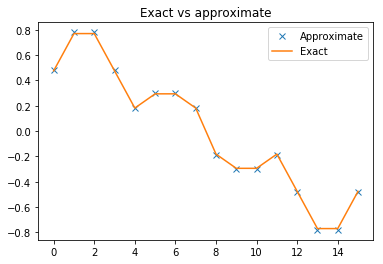

In [3]:
#define exact and f function 
exact = lambda x, y: np.sin(np.pi*x)*np.cos(np.pi*y)
f = lambda x, y: -(2*np.pi**2*np.sin(np.pi*x)*np.cos(np.pi*y))

#boundary conditions
uc = 0
ub = lambda x: np.sin(np.pi*x)
ua = lambda x: -(np.sin(np.pi*x))
ud = 0

#call 2d solver 
U, X, Y = finiteDifference2D(f, ua, ub, uc, ud, 4)

plt.plot(U, 'x',label='Approximate')
plt.plot(exact(X,Y).flatten().T, label='Exact')
plt.title('Exact vs approximate')
plt.legend()

In [4]:
def finiteDiffConvergence2D(f, ua, ub, uc, ud):
    
    """
    This function performs a convergence study 
    """

    #array of different values of N
    N = [4, 8, 16, 32, 64]

    #initialize empty array to hold error
    x = []

    #loop through N values in Narray 
    for h in N:
        #call finite different functions 
        U, X, Y = finiteDifference2D(f, ua, ub, uc, ud, h)
        #find error from approximate value and exact 
        E = U - exact(X,Y).flatten().T
        
        #calculate the l2 and linf norm 
        x.append(np.linalg.norm(E, 2)/h)        
    
    #return norm
    return x, N

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotLoglog(X, NN):
    """
    This function plots a convergence study on the approximated solutions 
    
    Inputs:
        X - l2 norm of approximated solution 
        Y - linf norm of the approximated solution 
        NN - array of N input sizes 
    """
    
    #calculate slope 
    m1 = (np.log(3.3820648128805106e-05/0.00013323158451803297))/(np.log(64/32))
    txt = 'Slope of the loglog plot for l2 norm ' + str(round(m1,6))
    
    plt.loglog(NN, X)
    plt.xlabel('Step Size N')
    plt.ylabel('l2 norm of error')
    plt.title('Loglog plot')
    plt.show()
    
    return txt

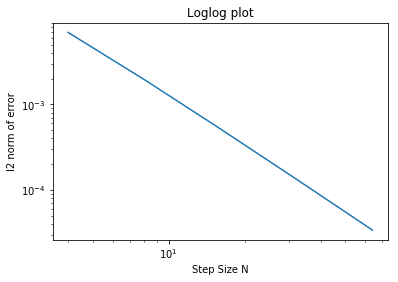

'Slope of the loglog plot for l2 norm -1.97796'

In [6]:
#perform and plot convergence study 
X, NN = finiteDiffConvergence2D(f, ua, ub, uc, ud)
plotLoglog(X, NN)

# Mean Weighted Residuals

## Exercise

In [7]:
def galerkinMWR(a, N, x, f):

    #create main diagonal for matrix A 
    main_diag = np.array([((1 + a*i**2) * np.pi) for i in range(1,11)])

    #insert 2pi to start of main diagonal 
    main_diag = np.insert(main_diag, 0, 2*np.pi)

    #create sparse matrix
    A = sparse.diags(main_diag, shape=(N+1,N+1)).toarray()

    #evaluate the right hand side 
    func = np.zeros(N+1)

    for i in range(N+1):
        func[i] = f(i)

    #use numpys backslash operator to solve linear function
    c = np.linalg.solve(A, func)

    #initialize sum value 
    summ = 0

    #calculate the residual 
    for j in range(1, N+2):
        summ =  summ + ((j-1)**2)*a*c[j-1]*np.cos((j-1)*x) + (c[j-1]*np.cos((j-1)*x))

    R = summ - np.exp(np.cos(x))
    
    #return residual
    return R

In [8]:
#define initial variable
a = 0.1
N = 10
x = np.arange(0,2*np.pi,0.01)
f = lambda n: 2*np.pi*iv(n,1)

R = galerkinMWR(a, N, x, f)

Text(0.5, 1.0, 'Mean Weighted Residual for the Galerkin Linear System')

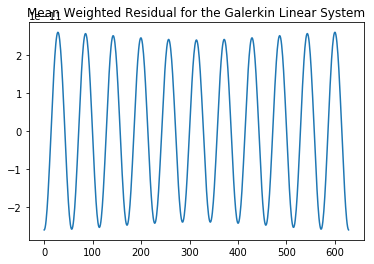

In [9]:
#plot residual 
plt.plot(R)
plt.title('Mean Weighted Residual for the Galerkin Linear System')